In [1]:
from gupb_ext import GUPBExt

import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from chex import PRNGKey, Array
from typing import Dict
import matplotlib.pyplot as plt
from reinforced_lib import RLib
from reinforced_lib.agents.mab import UCB, EGreedy, Softmax
from reinforced_lib.agents import BaseAgent
from tqdm import tqdm

tfd = tfp.distributions

In [2]:
def run_agent(agent: RLib, rewards: Array, n_steps: int, key: PRNGKey):
    
    act = 0
    act_acc = [act]
    reward_acc = [rewards[act].sample(seed=key)]
    for _ in tqdm(range(n_steps)):
        key, subkey = jax.random.split(key)
        act = agent.sample(reward_acc[-1])
        act_acc.append(act)
        reward_acc.append(rewards[act].sample(seed=subkey))
    
    return act_acc, reward_acc

In [3]:
rewards = [
    tfd.Normal(loc=jnp.sqrt(i), scale=.1) for i in range(10, 101, 10)
]

In [4]:
agents = {
    'EGreedy': RLib(
        agent_type=EGreedy,
        agent_params={'e': 0.01, 'optimistic_start': 0.0},
        ext_type=GUPBExt,
        ext_params={'n_arms': len(rewards)}
    ),
    'Softmax': RLib(
        agent_type=Softmax,
        agent_params={'lr': 2., 'tau': 8.7, 'multiplier': 0.02},
        ext_type=GUPBExt,
        ext_params={'n_arms': len(rewards)}
    ),
    'UCB': RLib(
        agent_type=UCB,
        agent_params={'c': 5},
        ext_type=GUPBExt,
        ext_params={'n_arms': len(rewards)}
    )
}

In [5]:
results_dict = {}
n_steps = 5000
for agent_name, agent in agents.items():
    key = jax.random.PRNGKey(324)
    act_acc, reward_acc = run_agent(agent, rewards, n_steps, key)
    results_dict[agent_name] = {
        "actions": act_acc,
        "rewards": reward_acc
    }

100%|██████████| 5000/5000 [00:03<00:00, 1398.70it/s]


In [9]:
def plot_resuls(results_dict: Dict, scatter: bool = True):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    for agent_name, result in results_dict.items():
        n_steps = len(result['actions'])
        if scatter:
            ax[0].scatter(range(n_steps), result['actions'], label=agent_name, s=1, alpha=0.75)
            ax[1].scatter(range(n_steps), result['rewards'], label=agent_name, s=1, alpha=0.75)
        else:
            ax[0].plot(range(n_steps), result['actions'], label=agent_name)
            ax[1].plot(range(n_steps), result['rewards'], label=agent_name)
    ax[0].set_title('Actions')
    ax[1].set_title('Rewards')
    ax[0].legend()
    ax[1].legend()
    plt.show()

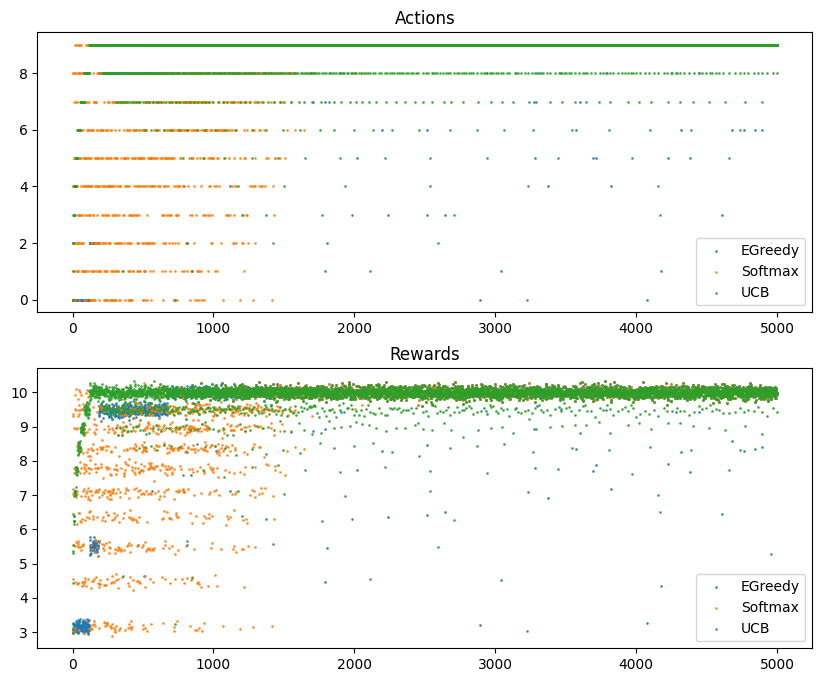

In [10]:
plot_resuls(results_dict)